In [1]:
import os
import pandas as pd
import numpy as np
import math
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser
import io
import base64
from IPython.display import HTML
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [2]:
chunk_size = 100000

chunk_num_train = pd.read_csv("../../data/train_numeric.csv",     chunksize = chunk_size)
chunk_dat_train = pd.read_csv("../../data/train_date.csv"   ,     chunksize = chunk_size)
chunk_cat_train = pd.read_csv("../../data/train_categorical.csv", chunksize = chunk_size)

df_num_train = chunk_num_train.get_chunk(chunk_size)
df_dat_train = chunk_dat_train.get_chunk(chunk_size)
df_cat_train = chunk_cat_train.get_chunk(chunk_size)

C:\Users\Tomonobu\Anaconda3\lib\site-packages\ipykernel\zmqshell.py:533: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,41,42,43,44,45,46,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,188,189,190,191,192,193,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,324,335,337,340,342,344,346,348,351,354,357,360,363,366,369,372,375,378,381,384,387,390,393,396,399,402,

 
OKデータをアンダーサンプリングする

In [3]:
# 全部 NaN な列をdropして、Nanを大きな値で置換。
print("before" + str(df_num_train.shape))
df_num_train.dropna(how='all', axis=1, inplace=True)
df_num_train.fillna(999, inplace=True)
print("after" + str(df_num_train.shape))

before(100000, 970)
after(100000, 970)


In [4]:
df_num, df_validation = train_test_split(df_num_train)

カテゴリカルデータも対応するIDだけ残す

In [5]:
# カテゴリ変数のパース(仮実装で、値に変換するだけ)
# 最終的にはビットマップっぽいので、エンコーディングする。
from parse import *
def cat_data_to_val(x):
    if type(x) is str:
        r = parse("T{}", x)
        return float(r[0])
    else:
        return x


In [6]:

def is_bit_on(s, pos):
    if type(s) is str:
        r = parse("T{}", s)
        val = (int(r[0]))
        mask = 1 << pos
        if val & mask:
            return 1
        else:
            return 0
    else:
        return 0

In [7]:
def decode_categorical_data(df):
    for column_name, item in df.iteritems():
        if column_name != 'Id':
            vallist = item.unique()
            bitlist = []
            for c in vallist:
                if type(c) is str:
                    r = parse("T{}", c)
                    val = int(r[0])
                    if val < 0:
                        val = val + 4294967296
                    for bitpos in range(0, 32):                        
                        mask = 1 << bitpos
                        if val & mask: 
                            if (bitpos not in bitlist):
                                bitlist.append(bitpos)

            for bit in bitlist:
                df[column_name + "_bit_" + str(bit)] = df[column_name].apply(lambda x:is_bit_on(x, bit)).astype('int8')
            df.drop(column_name, axis=1, inplace=True)

    

In [8]:
decode_categorical_data(df_cat_train)

In [9]:
df_num_ok = df_num[df_num['Response'] == 0]
df_num_ng = df_num[df_num['Response'] == 1]

undersample_rate = len(df_num_ng) * 20 / len(df_num_ok)
df_num_ok_sample = df_num_ok.sample(frac = undersample_rate)

df_num_balance = pd.concat([df_num_ok_sample, df_num_ng])
print('Response = 0のテーブル', df_num_ok.shape)
print('Response = 1のテーブル', df_num_ng.shape)
print('Response = 0をアンダーサンプルした後のフレーム', df_num_balance.shape)

Response = 0のテーブル (74589, 970)
Response = 1のテーブル (411, 970)
Response = 0をアンダーサンプルした後のフレーム (8631, 970)


In [10]:
df_cat_train.columns

Index(['Id', 'L0_S1_F25_bit_0', 'L0_S1_F27_bit_0', 'L0_S1_F27_bit_3',
       'L0_S1_F29_bit_0', 'L0_S1_F31_bit_0', 'L0_S1_F31_bit_3',
       'L0_S2_F33_bit_0', 'L0_S2_F35_bit_5', 'L0_S2_F35_bit_4',
       ...
       'L3_S49_F4230_bit_4', 'L3_S49_F4230_bit_2', 'L3_S49_F4232_bit_0',
       'L3_S49_F4234_bit_0', 'L3_S49_F4235_bit_4', 'L3_S49_F4235_bit_2',
       'L3_S49_F4237_bit_0', 'L3_S49_F4239_bit_0', 'L3_S49_F4240_bit_4',
       'L3_S49_F4240_bit_2'],
      dtype='object', length=2595)

In [11]:
df_train = pd.merge(df_num_balance, df_cat_train, on=['Id'], how = 'left')
df_test  = pd.merge(df_validation, df_cat_train, on=['Id'], how = 'left')


In [12]:
print(df_train[df_train.isnull().any(axis=1)])

Empty DataFrame
Columns: [Id, L0_S0_F0, L0_S0_F2, L0_S0_F4, L0_S0_F6, L0_S0_F8, L0_S0_F10, L0_S0_F12, L0_S0_F14, L0_S0_F16, L0_S0_F18, L0_S0_F20, L0_S0_F22, L0_S1_F24, L0_S1_F28, L0_S2_F32, L0_S2_F36, L0_S2_F40, L0_S2_F44, L0_S2_F48, L0_S2_F52, L0_S2_F56, L0_S2_F60, L0_S2_F64, L0_S3_F68, L0_S3_F72, L0_S3_F76, L0_S3_F80, L0_S3_F84, L0_S3_F88, L0_S3_F92, L0_S3_F96, L0_S3_F100, L0_S4_F104, L0_S4_F109, L0_S5_F114, L0_S5_F116, L0_S6_F118, L0_S6_F122, L0_S6_F132, L0_S7_F136, L0_S7_F138, L0_S7_F142, L0_S8_F144, L0_S8_F146, L0_S8_F149, L0_S9_F155, L0_S9_F160, L0_S9_F165, L0_S9_F170, L0_S9_F175, L0_S9_F180, L0_S9_F185, L0_S9_F190, L0_S9_F195, L0_S9_F200, L0_S9_F205, L0_S9_F210, L0_S10_F219, L0_S10_F224, L0_S10_F229, L0_S10_F234, L0_S10_F239, L0_S10_F244, L0_S10_F249, L0_S10_F254, L0_S10_F259, L0_S10_F264, L0_S10_F269, L0_S10_F274, L0_S11_F282, L0_S11_F286, L0_S11_F290, L0_S11_F294, L0_S11_F298, L0_S11_F302, L0_S11_F306, L0_S11_F310, L0_S11_F314, L0_S11_F318, L0_S11_F322, L0_S11_F326, L0_S12_F33

In [13]:
import xgboost as xgb


def separate_X_y(df):
    X = df.drop(['Response'], axis=1)
    y = df['Response']
    return X, y

 

C:\Users\Tomonobu\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:


def train_with_r_forest(df):
    X_train, y_train = separate_X_y(df)

    cl_weight = {0:0.3, 1:0.7}
    
    rf = RandomForestClassifier(max_depth=100,n_estimators=200)
    rf.fit(X_train, y_train)
    return rf





In [15]:
rf = train_with_r_forest(df_train)
X_test, y_test = separate_X_y(df_test)
y_pred = rf.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [16]:

from sklearn.metrics import confusion_matrix
cf_mat = confusion_matrix(y_test, y_pred)
cf_mat

array([[24746,    97],
       [  129,    28]], dtype=int64)

In [17]:
def calc_mcc(cf_mat):
    tn, fp, fn, tp = cf_mat.ravel()
    print(tn, fp, fn, tp)
    mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return mcc

mcc = calc_mcc(cf_mat)
print(mcc)
    

24746 97 129 28
0.195370932879


1   Id   0.0121966809855
2   L3_S30_F3774   0.00716342664845
3   L3_S33_F3857   0.00714540121846
4   L3_S33_F3859   0.00699555927192
5   L3_S29_F3436   0.00679305319467
6   L3_S33_F3865   0.00676110665379
7   L3_S29_F3430   0.00673752501873
8   L3_S29_F3449   0.00639158921673
9   L3_S33_F3855   0.0062985484611
10   L3_S30_F3784   0.00618060157397
11   L3_S30_F3554   0.00613897874062
12   L3_S30_F3749   0.0060278502879
13   L3_S29_F3442   0.00600136625682
14   L3_S30_F3494   0.0059993866814
15   L3_S29_F3458   0.00599091752503
16   L3_S33_F3863   0.00598891999889
17   L3_S30_F3499   0.00590091289609
18   L3_S29_F3455   0.00582603384127
19   L3_S32_F3854_bit_9   0.00578302255597
20   L3_S30_F3804   0.00575365090852
21   L3_S29_F3370   0.00571807615071
22   L3_S32_F3850   0.0057033320401
23   L3_S30_F3744   0.00570034067733

C:\Users\Tomonobu\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':



24   L3_S29_F3327   0.00565679890821
25   L3_S30_F3829   0.00564786434239
26   L3_S29_F3348   0.00563892831952
27   L3_S33_F3861   0.00560310132532
28   L3_S29_F3424   0.00558117383968
29   L3_S30_F3819   0.00557830968056
30   L1_S24_F1723   0.00547810932095
31   L3_S29_F3339   0.00543239576595
32   L3_S30_F3754   0.00537159827438
33   L3_S29_F3318   0.0053686467897
34   L3_S30_F3759   0.00526453952146
35   L3_S29_F3330   0.00525723988179
36   L3_S29_F3351   0.00520789321166
37   L3_S31_F3849_bit_7   0.0051323190995
38   L3_S29_F3333   0.005126999019
39   L3_S29_F3376   0.00510869476914
40   L3_S30_F3809   0.00506909277413
41   L3_S29_F3388   0.00504095382525
42   L1_S24_F1846   0.00501992182684
43   L3_S30_F3539   0.00498819030245
44   L3_S30_F3544   0.00497326526175
45   L3_S29_F3382   0.00494383035805
46   L3_S30_F3534   0.00488762203166
47   L3_S29_F3395   0.00485762690592
48   L3_S29_F3379   0.00477459268628
49   L3_S29_F3342   0.00474149216078
50   L3_S29_F3315   0.0047413318367

288   L3_S40_F3984   0.000802423063285
289   L3_S36_F3934   0.000798058715283
290   L0_S17_F433   0.000794211710483
291   L0_S3_F76   0.000790617178692
292   L3_S29_F3423_bit_0   0.000790402821722
293   L3_S41_F4020   0.000790159624697
294   L0_S12_F334   0.000789122282485
295   L3_S36_F3930   0.000787669790051
296   L2_S27_F3129   0.00078683745742
297   L0_S12_F342   0.000784647590078
298   L0_S21_F487   0.000775444014109
299   L3_S41_F4018   0.000767515430323
300   L3_S40_F3980   0.00076308609081
301   L1_S24_F1609   0.000760106074282
302   L0_S19_F455   0.000756116063153
303   L0_S19_F459   0.000753570056664
304   L1_S25_F2443   0.000751599937262
305   L3_S35_F3903   0.000751494645592
306   L0_S22_F561   0.000744294297129
307   L2_S27_F3140   0.000743892190797
308   L3_S45_F4124   0.000735580353757
309   L1_S24_F1753   0.00073174207069
310   L2_S27_F3199   0.000729405047211
311   L2_S27_F3206   0.000727694619735
312   L0_S21_F532   0.000717730914409
313   L0_S21_F537   0.00071089178

952   L1_S24_F1656_bit_6   5.77822638332e-05
953   L1_S24_F1641_bit_6   5.77249658581e-05
954   L1_S25_F2975   5.76375766717e-05
955   L1_S24_F736_bit_0   5.7572955249e-05
956   L1_S24_F1356   5.70311852874e-05
957   L1_S24_F1716_bit_0   5.63507957785e-05
958   L3_S44_F4100   5.61238444751e-05
959   L1_S25_F2650_bit_0   5.60244854137e-05
960   L1_S24_F1411   5.59302588359e-05
961   L1_S25_F1948   5.57957759741e-05
962   L1_S25_F1929   5.57523708274e-05
963   L1_S25_F2852   5.54565358732e-05
964   L1_S25_F2327   5.51721455521e-05
965   L1_S24_F1658_bit_0   5.51717169096e-05
966   L1_S24_F1585_bit_18   5.49966769305e-05
967   L1_S25_F2930   5.48276826606e-05
968   L2_S28_F3254_bit_1   5.45302971712e-05
969   L1_S24_F1094   5.443774619e-05
970   L3_S45_F4130   5.42976086699e-05
971   L1_S24_F1180   5.40419691561e-05
972   L1_S25_F2220   5.3879495768e-05
973   L1_S24_F825_bit_0   5.38524487238e-05
974   L1_S25_F1958   5.33637586892e-05
975   L1_S25_F2940   5.29578655057e-05
976   L1_S25_F2

1946   L1_S25_F2245   0.0
1947   L1_S25_F2322   0.0
1948   L0_S9_F164_bit_6   0.0
1949   L0_S9_F164_bit_7   0.0
1950   L0_S9_F164_bit_8   0.0
1951   L0_S9_F189_bit_9   0.0
1952   L0_S9_F194_bit_13   0.0
1953   L0_S9_F194_bit_12   0.0
1954   L0_S9_F194_bit_11   0.0
1955   L0_S9_F194_bit_10   0.0
1956   L0_S9_F194_bit_8   0.0
1957   L0_S9_F194_bit_7   0.0
1958   L0_S9_F194_bit_6   0.0
1959   L0_S9_F194_bit_2   0.0
1960   L0_S9_F193_bit_0   0.0
1961   L0_S9_F191_bit_0   0.0
1962   L0_S9_F189_bit_0   0.0
1963   L0_S9_F189_bit_4   0.0
1964   L0_S9_F189_bit_24   0.0
1965   L0_S9_F189_bit_5   0.0
1966   L0_S9_F189_bit_15   0.0
1967   L0_S9_F194_bit_5   0.0
1968   L0_S9_F189_bit_13   0.0
1969   L0_S9_F189_bit_12   0.0
1970   L0_S9_F189_bit_11   0.0
1971   L0_S9_F189_bit_10   0.0
1972   L0_S9_F189_bit_7   0.0
1973   L0_S9_F189_bit_6   0.0
1974   L0_S9_F189_bit_2   0.0
1975   L0_S9_F189_bit_3   0.0
1976   L0_S9_F188_bit_0   0.0
1977   L0_S9_F186_bit_0   0.0
1978   L0_S9_F184_bit_0   0.0
1979   L

3480   L1_S24_F861_bit_10   0.0
3481   L1_S24_F861_bit_4   0.0
3482   L1_S24_F861_bit_3   0.0
3483   L1_S24_F860_bit_0   0.0
3484   L1_S24_F856_bit_8   0.0
3485   L1_S24_F856_bit_6   0.0
3486   L1_S24_F856_bit_3   0.0
3487   L1_S24_F856_bit_2   0.0
3488   L1_S24_F855_bit_0   0.0
3489   L1_S24_F852_bit_3   0.0
3490   L1_S24_F851_bit_0   0.0
3491   L1_S24_F848_bit_10   0.0
3492   L1_S24_F848_bit_8   0.0
3493   L1_S24_F848_bit_6   0.0
3494   L1_S24_F876_bit_3   0.0
3495   L1_S24_F876_bit_10   0.0
3496   L1_S24_F848_bit_2   0.0
3497   L1_S24_F880_bit_0   0.0
3498   L1_S24_F914_bit_0   0.0
3499   L1_S24_F906_bit_10   0.0
3500   L1_S24_F906_bit_2   0.0
3501   L1_S24_F901_bit_10   0.0
3502   L1_S24_F901_bit_8   0.0
3503   L1_S24_F901_bit_3   0.0
3504   L1_S24_F901_bit_2   0.0
3505   L1_S24_F900_bit_0   0.0
3506   L1_S24_F896_bit_8   0.0
3507   L1_S24_F896_bit_2   0.0
3508   L1_S24_F895_bit_0   0.0
3509   L1_S24_F891_bit_10   0.0
3510   L1_S24_F891_bit_6   0.0
3511   L1_S24_F891_bit_4   0.0
35

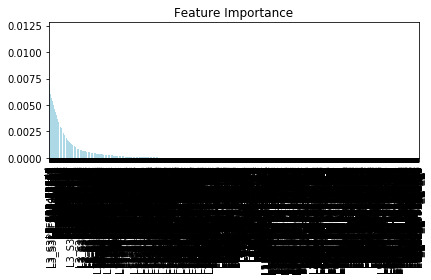

In [18]:
def plot_feature_importance(clf, df):
    #特徴量の重要度
    feature = clf.feature_importances_

    #特徴量の重要度を上から順に出力する
    f = pd.DataFrame({'number': range(0, len(feature)),
                 'feature': feature[:], 'name':''})
    f2 = f.sort_values('feature',ascending=False)
    f3 = f2.ix[:, 'number']

    #特徴量の名前
    label = df.columns[0:]

    #特徴量の重要度順（降順）
    indices = np.argsort(feature)[::-1]

    for i in range(len(feature)):
        print(str(i + 1) + "   " + str(label[indices[i]]) + "   " + str(feature[indices[i]]))
        f2.iloc[i, 1]  = str(label[indices[i]])

    plt.title('Feature Importance')
    plt.bar(range(len(feature)),feature[indices], color='lightblue', align='center')
    plt.xticks(range(len(feature)), label[indices], rotation=90)
    plt.xlim([-1, len(feature)])
    plt.tight_layout()
    plt.show()
    
    return f2


f_importance = plot_feature_importance(rf, df_train)
f_importance.to_csv("../../data/bosch_0620_features.csv", index=False)

In [20]:
df_train_id_drop = df_train.drop(['Id'], axis=1)
rf2 = train_with_r_forest(df_train_id_drop)
X_test, y_test = separate_X_y(df_test)
y_pred = rf.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

C:\Users\Tomonobu\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


1   L3_S29_F3330   0.00730359493625
2   L3_S33_F3859   0.00723460617438
3   L3_S33_F3865   0.00718446065581
4   L3_S33_F3857   0.00703610436633
5   L3_S30_F3494   0.00671019593775
6   L3_S29_F3348   0.00657892505087
7   L3_S33_F3861   0.00626170333017
8   L3_S30_F3829   0.00615469548301
9   L3_S30_F3774   0.00609480229893
10   L3_S33_F3855   0.00606679666012
11   L3_S29_F3436   0.00603928258041
12   L3_S30_F3554   0.00595009438259
13   L3_S30_F3819   0.00592183477545
14   L3_S30_F3539   0.00589268549429
15   L3_S30_F3809   0.00581075313852
16   L3_S29_F3442   0.00577371395509
17   L3_S30_F3519   0.00574790027704
18   L3_S29_F3424   0.00574522979308
19   L3_S30_F3499   0.00570880536569
20   L3_S30_F3784   0.0056870110147
21   L3_S29_F3327   0.00567543156471
22   L3_S32_F3854_bit_9   0.00565127718091
23   L3_S30_F3749   0.00564504944301
24   L3_S29_F3395   0.00564403311489
25   L3_S29_F3333   0.00562147587152
26   L3_S29_F3376   0.00551158891439
27   L3_S30_F3794   0.00550534450107
28   

852   L3_S51_F4256   8.02545646122e-05
853   L3_S44_F4120_bit_0   8.00847870716e-05
854   L1_S25_F2716   7.97828415788e-05
855   L2_S28_F3259   7.95201148304e-05
856   L1_S24_F1605_bit_0   7.92909257877e-05
857   L1_S25_F3020   7.91047532773e-05
858   L1_S24_F1668_bit_0   7.90952301346e-05
859   L1_S25_F2161   7.90815636988e-05
860   L1_S25_F2411   7.89904069373e-05
861   L3_S40_F3994   7.82992856334e-05
862   L1_S24_F1656_bit_16   7.80055531225e-05
863   L1_S24_F1010   7.79675497987e-05
864   L1_S25_F2493   7.72706322669e-05
865   L1_S24_F1623_bit_0   7.70547021862e-05
866   L1_S25_F2317   7.70406081559e-05
867   L1_S25_F1997   7.70326079908e-05
868   L1_S24_F1545_bit_0   7.6744266116e-05
869   L3_S44_F4111_bit_0   7.65973626868e-05
870   L1_S25_F2016   7.63901776177e-05
871   L3_S49_F4216   7.62785315167e-05
872   L1_S24_F1638_bit_0   7.62417488624e-05
873   L1_S25_F2307   7.60927494099e-05
874   L1_S25_F2233   7.59739513369e-05
875   L3_S43_F4099_bit_2   7.58834668151e-05
876   L3_S

1842   L0_S2_F61_bit_0   0.0
1843   L0_S2_F59_bit_6   0.0
1844   L0_S2_F59_bit_4   0.0
1845   L0_S2_F59_bit_5   0.0
1846   L0_S2_F57_bit_0   0.0
1847   L0_S2_F55_bit_6   0.0
1848   L0_S2_F55_bit_4   0.0
1849   L0_S2_F55_bit_5   0.0
1850   L0_S2_F53_bit_0   0.0
1851   L0_S2_F51_bit_6   0.0
1852   L0_S2_F51_bit_4   0.0
1853   L0_S2_F51_bit_5   0.0
1854   L0_S2_F49_bit_0   0.0
1855   L0_S2_F47_bit_6   0.0
1856   L0_S2_F47_bit_4   0.0
1857   L0_S2_F47_bit_5   0.0
1858   L0_S2_F45_bit_0   0.0
1859   L0_S2_F43_bit_4   0.0
1860   L0_S2_F43_bit_5   0.0
1861   L0_S9_F153_bit_0   0.0
1862   L0_S9_F154_bit_2   0.0
1863   L0_S9_F164_bit_10   0.0
1864   L0_S9_F154_bit_6   0.0
1865   L0_S9_F164_bit_6   0.0
1866   L0_S9_F164_bit_2   0.0
1867   L0_S9_F164_bit_3   0.0
1868   L0_S9_F163_bit_0   0.0
1869   L0_S9_F159_bit_0   0.0
1870   L0_S9_F159_bit_4   0.0
1871   L0_S9_F159_bit_24   0.0
1872   L0_S9_F159_bit_5   0.0
1873   L0_S9_F159_bit_9   0.0
1874   L0_S9_F159_bit_15   0.0
1875   L0_S9_F159_bit_12  

2889   L0_S21_F521_bit_6   0.0
2890   L0_S21_F520_bit_0   0.0
2891   L0_S21_F518_bit_0   0.0
2892   L0_S21_F516_bit_9   0.0
2893   L0_S21_F516_bit_24   0.0
2894   L0_S21_F516_bit_4   0.0
2895   L0_S21_F525_bit_0   0.0
2896   L0_S21_F526_bit_7   0.0
2897   L0_S21_F531_bit_15   0.0
2898   L0_S21_F526_bit_8   0.0
2899   L0_S21_F531_bit_13   0.0
2900   L0_S21_F531_bit_12   0.0
2901   L0_S21_F531_bit_11   0.0
2902   L0_S21_F531_bit_10   0.0
2903   L0_S21_F531_bit_8   0.0
2904   L0_S21_F531_bit_7   0.0
2905   L0_S21_F531_bit_6   0.0
2906   L0_S21_F530_bit_0   0.0
2907   L0_S21_F528_bit_0   0.0
2908   L0_S21_F526_bit_9   0.0
2909   L0_S21_F526_bit_24   0.0
2910   L0_S21_F526_bit_4   0.0
2911   L0_S21_F526_bit_2   0.0
2912   L0_S21_F526_bit_0   0.0
2913   L0_S21_F526_bit_15   0.0
2914   L0_S21_F526_bit_13   0.0
2915   L0_S21_F526_bit_12   0.0
2916   L0_S21_F526_bit_11   0.0
2917   L0_S21_F526_bit_10   0.0
2918   L0_S22_F545_bit_11   0.0
2919   L0_S22_F545_bit_13   0.0
2920   L0_S21_F516_bit_0 

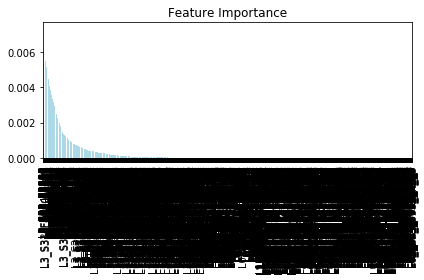

In [21]:


f_importance = plot_feature_importance(rf2, df_train_id_drop)
f_importance.to_csv("../../data/bosch_0620_features_id_drop.csv", index=False)

In [ ]:
df_cat

In [ ]:
df_num